In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create stiffness matrix from list of stiffness values of all the springs
def stiffnessMat(stiff):
    n = len(stiff)
    matrix = np.zeros(shape = (n, n))
    for i in range(0,n-1):
        matrix[i][i] += stiff[i] + stiff[i+1]
    
    matrix[n-1][n-1] += stiff[n-1]
    
    for i in range(1,n):
        matrix[i-1][i] += -stiff[i]
        matrix[i][i-1] += -stiff[i]
    return matrix

In [3]:
# Calculate displacement of each block from force and stiffness matrix
def calculateDisp(force, stiffMat):
    invStiff = np.linalg.inv(stiffMat)
    disp = np.matmul(invStiff,force)
    return disp

In [4]:
def PCA(displacement, n, m, r):
    
    #find mean displacement
    meanDisp = np.mean(displacement, axis = 0)
    
    #subtract mean from each of the data points
    for i in range (0,m):
        displacement[i] -= meanDisp
    
    #find covariance matrix of displacement
    covDisp = np.cov(displacement, rowvar = False, bias = True)
    
    #find eigen values and vectors for covariance matrix
    e,v = np.linalg.eig(covDisp)
    idx = np.argsort(e)
    e = e[idx]
    v = v[:,idx]
    eigenVectors = np.transpose(v)
    
    #new displacement vectors in terms of the new coordinate system generated from
    #eigen vectors corresponding to the r largest eigen values
    newDispVec = np.zeros(shape = (m,r))  
    
    #components of these new vectors in the original coordinate system,
    #so that we can compare it with actual displacement data to calculate MSE
    reduced = np.zeros(shape = (m,n))
    for i in range(0,m):
        for j in range(n-r,n):
            newDispVec[i][j-(n-r)] += np.dot(displacement[i] , eigenVectors[j])
            reduced[i] += np.dot(displacement[i], eigenVectors[j]) * eigenVectors[j]
            
    return eigenVectors, newDispVec, reduced
            

In [5]:
def modeShape(stiffMat, displacement, n, m, r):
    
    #find eigen values of stiffness matrix
    e,v = np.linalg.eig(stiffMat)
    idx = np.argsort(e)
    e = e[idx]
    v = v[:,idx]
    eigenVectors = np.transpose(v)
    
    #new displacement vectors in terms of the new coordinate system generated from
    #eigen vectors corresponding to the r smallest eigen values
    newDispVec = np.zeros(shape = (m,r))
    
    #components of these new vectors in the original coordinate system,
    #so that we can compare it with actual displacement data to calculate MSE
    reduced = np.zeros(shape = (m,n))
    for i in range(0,m):
        for j in range(0,r):
            newDispVec[i][j] += np.dot(displacement[i], eigenVectors[j])
            reduced[i] += np.dot(displacement[i], eigenVectors[j]) * eigenVectors[j]
            
    return eigenVectors, newDispVec, reduced

In [6]:
def MSE(dispOrig, dispNew, m):
    mse = 0
    for i in range(0,m):
        error = np.linalg.norm(dispOrig - dispNew)
        mse += error**2
    mse = mse/m
    return mse

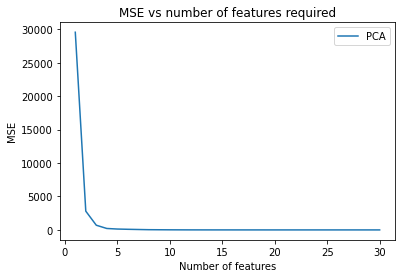

In [7]:
n = 30 # features
m = 100 # data points
forceMean = 0
forceDev = 10
stiffMean = 94
stiffDev = 50

#Generating random force values from normal distribution
forceValues = np.random.normal(forceMean, forceDev, size = (m,n))

#Generating random stiffness values from normal distribution
stiff = np.random.normal(stiffMean, stiffDev, n)

#Generating Stiffness Matrix from given stiffness values
K = stiffnessMat(stiff)

#Calculating displacement for given force and stiffness values
displacement = np.zeros(shape = (m,n))
displacement_error = np.zeros(shape = (m,n))
for i in range(0,m):
    displacement[i] = calculateDisp(forceValues[i], K)
    displacement_error[i] +=  displacement[i] + np.random.uniform(-1,1) * 0.1 * displacement[i]  #+/- 5% error

#MSE for PCA Approach
mse = np.zeros(n)
mse_error = np.zeros(n)
rValues = np.zeros(n)

#evPCA, temp1 = PCA(displacement,n,m,1)
#evModeShape,temp2 = modeShape(K, displacement,n,m,n-3)
#print(evPCA)
#print(evModeShape)

eigPCA = np.zeros(n)
#Calculating MSE for both the approaches
for i in range(0,n):
    r = i+1
    rValues[i] = r
    eigPCA, newDisp, red = PCA(displacement,n,m,r)
    eigPCA_error, newDisp_error, red_error = PCA(displacement_error,n,m,r)
    mse[i] = MSE(displacement, red, m)
    mse_error[i] = MSE(displacement, red_error, m)

eigMS, newDispMs, redMS = modeShape(K, displacement, n , m , r)
#print("Eigen Vectors for PCA")
#print(eigPCA)
#print("Eigen Vectors of Mode Shape")
#print(eigMS)
plt.plot(rValues, mse, label = "PCA")
#plt.plot(rValues, mse_error, label = "PCA Error")
plt.title("MSE vs number of features required")
plt.xlabel("Number of features")
plt.ylabel("MSE")
plt.legend()
plt.show()

